# Matched multiomic data from PBMC
We will work through the example of 10X multi-omics data from Peripheral Blood Mononuclear Cells.  The data are freely available from 10X and we supply another jupyter notebook downloads the data from 10X and counts the unspliced and spliced transcripts.

### Preliminaries
We begin in the usual fashion by importing needed packages.  We load modules specific to MultiDynamo here.  Classes and methods of MultiDynamo have all been added to a single folder 'multi' that is parallel to 'preprocessing', 'estimation', 'prediction', etc.  When fully incorportated into dynamo this will disappear.

In [1]:
import warnings
warnings.simplefilter('ignore', category=Warning)

import dynamo as dyn
import matplotlib.pyplot as plt
import muon as mu
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import scanpy as sc
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, frameon=False, facecolor='white')
from scipy.sparse import issparse, spmatrix
import sys

# MultiVelo related classes and methods - This will disappear if we fully incorporate into dynamo
PARENT_DIR = Path().resolve().parent
sys.path.append(os.path.join(PARENT_DIR, 'dynamo', 'dynamo', 'multi'))

from ATACseqTools import annotate_integrated_mdata, gene_activity, integrate
from MultiIO import read_10x_multiome_h5, read_10x_atac_rna_h5
from MultiPreprocessor import MultiPreprocessor
from MultiomicVectorField import MultiomicVectorField
from MultiVelocity import MultiVelocity

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.10.8 louvain==0.8.0 pynndescent==0.5.13


### Define paths
Here we define paths in a locale specific manner. I run on both OSX and Linux platforms with synching of data and results through the cloud; globals.py defines global variables in a platform aware manner.

You can either modify globals.py or just specify:
- Location of the MultiDynamo installation (BASE_PATH)
- Location of cache for intermediate results (CACHE_PATH)
- Location(s) of cellranger style 'outs' directory(ies) containing the counts data (MULTIOME_PATH or ATAC_PATH and RNA_PATH)
- Location to reference data, i.e. annotation in GTF format (GTF_PATH)

In [2]:
# Read in global variables from file
from globals import ATAC_PATH, CACHE_PATH, GTF_PATH, MULTIOME_PATH, RNA_PATH 

# ALTERNATIVELY, YOU CAN DEFINE THE FOLLOWING GLOBAL VARIABLES BELOW (DEFINE AND UNCOMMENT AS NEEDED)
# BASE_PATH = /your/MultiDynamo/path (should contain dynamo and multi)

# ... path to cache for intermediate results
# CACHE_PATH = /your/path/to/cache

# ... for matched multiomic data
# MULTIOME_PATH = /your/path/to/multiome/outs

# ... for unmatched multiomic data
# ATAC_PATH = /your path to/atac/outs
# RNA_PATH = /your/path/to/rna/outs

# ... path to genome annotation
# GTF_PATH = /your/local/human/genome/gtf

## Load data
Multi-omic data comes in one of two forms generally: (1) Matched data from multiple modaliies for each cell or (2) Unmatched data from different modalities for different cells.  The latter requires additional integration steps.  Here we'll demonstrate the matched case.  We'll provide another jupyter notebook for the (more time consuming) unmatched case.

The input data will be (one or two) 'outs' folders containing cellranger output and in parallel a velocyto directory containing the loom file of spliced and uncpliced reads as computed by velocyto.

***Note: This automatically reads in a loom file of splicing counts computed by velocyto.  We provide a separate notebook to download the relevant files from 10X genomics and count the spliced/unspliced reads.***

In [3]:
# Read in matched data
matched_mdata = read_10x_multiome_h5(multiome_base_path=MULTIOME_PATH)

|-----> Deserializing MATCHED scATAC-seq and scRNA-seq data ...
|-----------> reading the multiome h5 file ...
Added `interval` annotation for features from /data/LIRGE/external_data/multiome/outs/filtered_feature_bc_matrix.h5
|-----------------> <insert> .uns[matched_atac_rna_data] = True
|-----------------> <insert> path to fragments file in .uns['files'] ...
|-----------> adding peak annotation ...
|-----------> homogenizing cell indices ...
|-----------> adding splicing data ...
|-----> [read_10x_multiome_h5] completed [80.6573s]


#### Checkpoint
This is a checkpoint that serializes the MuData object to cache.  We'll implement a less visible and automated mechanism to accomplish this later.

In [4]:
matched_mdata.write(os.path.join(CACHE_PATH, 'matched_mdata.h5mu'))

## Pre-processing
Here we carry out preprocessing as specified in recipes in the manner carried out by dynamo.  Preprocessing of scATAC-seq data involves computing latent semantic indexing, followed by filtering of cells and peaks.  Preprocessing of scRNA-seq data uses functionality already build into dynamo.

In [5]:
# Instantiate a multi-omic preprocessor
multi_preprocessor = MultiPreprocessor(cell_cycle_score_enable=False)

# Preprocess
multi_preprocessor.preprocess_mdata(matched_mdata,
                                    recipe_dict={'atac': 'muon', 'rna': 'monocle'})

|-----> Running muon preprocessing pipeline for scATAC-seq data ...


Reading Fragments: 100%|██████████████████████████████████████████████████████████| 1000000/1000000 [00:04<00:00, 241416.99it/s]


|-----------> filtered out 0 outlier features
|-----------> filtered out 240 outlier cells
|-----------> filtered out 234 outlier cells
|-----> computing TF-IDF
|-----> normalizing
|-----> feature selection
|-----------> identified 9405 highly variable features
|-----> computing latent sematic indexing
|-----------> <insert> X_lsi key in .obsm
|-----------> <insert> LSI key in .varm
|-----------> <insert> [lsi][stdev] key in .uns
|-----> [preprocess_atac_muon] completed [146.3150s]
|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 52 outlier cells
|-----------> filtered out 17351 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [64.9871s]


#### Checkpoint
This is another checkpoint that serializes the preprocessed MuData object to cache.

In [6]:
matched_mdata.write(os.path.join(CACHE_PATH, 'preprocessed_matched_mdata.h5mu'))

## Integration
For matched data, integration is a trivial task - merely a matter of restricting the data to cell with data passing QC in all modalities.  For unmatched samples this is a harder problem for which we have implemented several solutions in the accompanying notebook.

In [7]:
integrated_matched_mdata = integrate(mdata = matched_mdata,
                                     gtf_path = GTF_PATH)

|-----> Integration: matched multiome, so just filtering cells


#### Checkpoint
A checkpoint serializing the integrated and preprocessed MuData object to cache.

In [8]:
integrated_matched_mdata.write(os.path.join(CACHE_PATH, 'integrated_matched_mdata.h5mu'))

## Annotate cells
We use CellTypist for automated cell type annotation of the cells.  This is not essentially, but gives us something more interesting to look at in our visualizations.

#### Recovery from checkpoint
Here we demonstrate deserializing from cache.  This is not essential.  If the object is resident in memory you can skip this step.

In [9]:
integrated_matched_mdata = mu.read(os.path.join(CACHE_PATH, 'integrated_matched_mdata.h5mu'))

The actual automated annotation ...

In [10]:
integrated_matched_mdata = annotate_integrated_mdata(integrated_matched_mdata)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 50
📂 Storing models in /home/cordessf/.celltypist/data/models
💾 Downloading model [1/50]: Immune_All_Low.pkl
💾 Downloading model [2/50]: Immune_All_High.pkl
💾 Downloading model [3/50]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/50]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/50]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [6/50]: Adult_Human_Skin.pkl
💾 Downloading model [7/50]: Adult_Mouse_Gut.pkl
💾 Downloading model [8/50]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [9/50]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [10/50]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [11/50]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [12/50]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [13/50]: COVID19_Immune_Landscape.pkl
💾 Downloading model [14/50]: Cells_Adult_Breast.pkl
💾 Downloading model [15/50]: Cells_Fetal_Lung.pkl

## Optional Step: Filtering out T cells
We'll filter out everything except for T cells.  It speeds subsequent computations and we we are primarily interested in T cell development.

In [11]:
integrated_matched_mdata.write(os.path.join(CACHE_PATH, 'annotated_integrated_matched_mdata.h5mu'))

In [12]:
# Extract the predicted cell types
cell_types = list(set(integrated_matched_mdata.mod['rna'].obs['cell_type']))
t_cell_types = [cell_type for cell_type in cell_types if 'T cell' in cell_type]
mask = [cell_type in t_cell_types for cell_type in integrated_matched_mdata.mod['rna'].obs['cell_type']]

# Filter the cells to T cells
integrated_matched_mdata = integrated_matched_mdata[mask, :].copy()

#### Checkpoint
This is a good point to serialize everything to cache.  We are done with preprocessing, integration and annotation and about to start the computation of multiomic velocities.

In [13]:
integrated_matched_mdata.write(os.path.join(CACHE_PATH, 'annotated_integrated_matched_tcell_mdata.h5mu'))

## Compute multi-omic velocity
We now proceed with the computation of multi-omic velocities.  Implemented are deterministic and stochastic computations.  The dynamical  models the kinetics of individual enhancers with the following linear ordinary differential equation:
\begin{equation}
\frac{d x (t)}{d t} = A \cdot x ( t ) + b
\end{equation}
where
\begin{equation}
x =
\begin{pmatrix}
e_i^{(1)} (t) \\ e_i^{(2)} (t) \\ \vdots \\ e_i^{(N_i)} (t) \\ u_i (t) \\ s_i (t)
\end{pmatrix}
\end{equation}
with $e_i^{(j)}$ are the [accessibility] 'status' of the $j$-th enhancer for gene $i$; $u_i (t)$ and $s_i (t)$ are the counts of unspliced and spliced transcripts of gene $i$.
The matrix of coefficients, $A$, and the inhomogeneous term, $b$, are time independent
\begin{equation}
\begin{split}
A =&
\begin{pmatrix}
-\omega_i^{(1)} & 0 & \dotsb & 0 & 0 & 0 \\
0 & -\omega_i^{(2)} & \dotsb & 0 & 0 & 0 \\
0 & 0 & \dotsb & 0& 0 & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & \dotsb & -\omega_i^{(N_i)} & 0 & 0 \\ 
\alpha_i^{(1)} & \alpha_i^{(2)} & \dotsb & \alpha_i^{(N_i)} & - \beta_i & 0 \\
0 & 0 & \dotsb & 0 & \beta_i & -\gamma_i 
\end{pmatrix} \\
b = &
\begin{pmatrix}
k_i^{(1)} \omega_i^{(1)} \\ k_i^{(2)} \omega_i^{(2)} \\ \vdots \\ k_i^{(N_i)} \omega_i^{(N_i)} \\ 0 \\ 0
\end{pmatrix}
\end{split}
\end{equation}
The $k_i^{(j)}$ are latent variables that capture the kinetic states of the enhancers: $k_i^{(j)} = 1$ indicates that the $j$-th enhancer for gene $i$ is becoming active, while $k_i^{(j)} = 0$ indicates that this enhancer is inactivating.

It is, at least in principle, straightfoward to solve a system of linear ordinary differential equations with time-independent coefficients:
\begin{equation}
x(t) = e^{A (t - t_0)} \cdot \left ( x( t_0 ) + A^{-1} \cdot b \right ) - A^{-1} \cdot b
\end{equation}
or more explicitly
\begin{equation}
\begin{split}
e_i^{(j)} (t) =& e^{- \omega_i^{(j)} t} \left ( e_i^{(j)} ( t_0 ) - k_i^{(j)} \right ) + k_i^{(j)} \qquad j = 1, \ldots, N_i \\
u_i (t) =& \thickspace e^{- \beta_i t} u_i (t_0) + \frac{1 - e^{-\beta_i t}}{\beta_i} \sum_{j=1}^{N_i} k_i^{(j)} \alpha_i^{(j)} \\
& \quad - \sum_{j=1}^{N_i} \frac{e^{- \beta_i t} - e^{-\omega_i^{(j)} t}}{\beta_i - \omega_i^{(j)}} \left ( e_i^{(j)} (t_0) - k_i^{(j)} \right ) \alpha_i^{(j)} \\
s_i (t) =& e^{-\gamma_i t} s_i (t_0)
+ \frac{1 - e^{- \gamma_i t}}{\gamma_i} \sum_{j = 1}^{N_i} k_i^{(j)} \alpha_i^{(j)} \\
& \quad + \frac{\beta_i \left ( e^{- \beta_i t} - e^{-\gamma_i t} \right )}{\beta_i - \gamma_i} \left ( u_i (t_0) - \frac{1}{\beta_i} \sum_{i=1}^{N_i} k_i^{(j)} \alpha_i^{(j)}
+ \sum_{i=1}^{N_i} \frac{\alpha_i^{(j)} \left (e_i^{(j)} (t_0) - k_i^{(j)} \right )}{\beta_i - \omega_i^{(j)}} \right ) \\
& \quad + \beta_i \sum_{j=1}^{N_i} \frac{\alpha_i^{(j)} \left ( e_i^{(j)} (t_0) - k_i^{(j)} \right ) \left ( e^{-\omega_i^{(j)} t} - e^{-\gamma_i t} \right )}{\left ( \beta_i - \omega_i^{(j)} \right) \left ( \gamma_i - \omega_i^{(j)} \right )}
\label{eq:ode_sol}
\end{split}
\end{equation}
where $e_i^{(j)} (t_0)$, $u_i (t_0)$ and $s_i(t_0)$ are the values of the enhancer activity and counts of unspliced and spliced transcripts, respectively.
The steady state values of all the states are given by
\begin{equation}
\begin{split}
\lim_{t \to \infty} e_i^{(j)} (t) =&  k_i^{(j)} \\
\lim_{t \to \infty} u_i (t) =& \frac{1}{\beta_i} \sum_{j=1}^{N_i} k_i^{(j)} \alpha_i^{(j)} \\
\lim_{t \to \infty} s_i (t) =& \frac{1}{\gamma_i} \sum_{j=1}^{N_i}  k_i^{(j)} \alpha_i^{(j)}
\end{split}
\end{equation}
This model includes separate latent variables, $k_i^{(j)}$, for the chromatin states of each \emph{cis}-regulatory element.
Thus for each gene, $g_i$, we have $4 N_i + 3$ model parameters, which we divide up as follows:
$\theta_i = \left ( \omega_i^{(1)},  \ldots,  \omega_i^{(N_i)}, \alpha_i^{(1)}, \ldots, \alpha_i^{(N_i)},\beta_i, \gamma_i \right )$ and $T_i = \left ( t_{o,i}^{(1)},  \ldots, t_{o,i}^{(N_i)},  t_{c,i}^{(1)}, \ldots,  t_{c,i}^{(N_i)}\right )$.

This is a mild generalization of MultiVelo; however the difference has computational implications.  Combinatorially the solution is probably too complex to implement in this fashion.

#### Recovery from check point
We recover the annotated and integrated object from cache.  This step is not necessary of the object is already memory resident.

In [14]:
# Read in annotated and integrated MuData object
integrated_matched_mdata = mu.read(os.path.join(CACHE_PATH, 'annotated_integrated_matched_tcell_mdata.h5mu'))

In [15]:
# Compute MultiVelocity from the annotated and integrated MuData object
multi_velocity = MultiVelocity(mdata=integrated_matched_mdata,
                               linkage_method='cellranger', # future: 'cicero' or 'scenic+'
                               neighbor_method='wnn') # 'wnn' or 'multivi')

multi_velocity.compute_velocities(num_processes=6)

|-----> Computing linkages via cellranger ...
|-----> [compute_linkages_via_cellranger] completed [36.9958s]
|-----> Starting computation of weighted nearest neighbors ...
|-----> Computing KNN distance matrices using default Scanpy implementation
|-----------> Computing modality weights
|-----------> Computing weighted distances for union of 200 nearest neighbors between modalities
|-----------------> 0 out of 5859 0.01 seconds elapsed
|-----------------> 2000 out of 5859 13.93 seconds elapsed
|-----------------> 4000 out of 5859 27.86 seconds elapsed
|-----------> Selecting top K neighbors
|-----> computing moments for transcriptomic data ...
|-----> 14567 genes will be fitted
|-----> Starting computation of integral neighbors ...


#### Checkpoint
We can convert MultiVelocity to a MuData object, serialize and read it back from disk.

In [16]:
# Serialize multi_velocity to disk - this involved conversion to MuData object
multi_velocity.write(os.path.join(CACHE_PATH, 'multi_velocity_tcell_adata.h5mu'))

## Reconstruction of the vector field
#### Recovery from checkpoint
We deserialize previously serialized computations.  You can skip this block if the MultiVelocity object is already memory resident.

In [17]:
# Read the MuData object
multi_velocity_md = mu.read(os.path.join(CACHE_PATH, 'multi_velocity_tcell_adata.h5mu'))

# Instantiate the MultiVelocity object
multi_velocity = MultiVelocity.from_mdata(multi_velocity_md)

Instantiate a MultiomicVectorField object from the MultiVelocity object.

In [18]:
multi_vector_field = MultiomicVectorField(multi_velocity)

#### Checkpoint:
We can extract from the MultiVectorField class an AnnData object that is suitable for further analysis using dynamo alone.  We'll extract it and save it in the block below.  We won't be using this below - just showing some functionality.

In [19]:
multi_vector_field.multi_adata.write(os.path.join(CACHE_PATH, 'multi_adata.h5ad'))

### Computation of the smooth analytic vector field

Or we can proceed on with methods from Multi

In [20]:
multi_adata = multi_vector_field.cell_velocities()

|-----> <insert> X_pca to obsm in AnnData Object.
|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [26.3122s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [44.5683s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [4.8117s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [1.5992s]
|-----> method arg is None, choosing meth

In [21]:
multi_vector_field.compute_vector_field()

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [SparseVFC] completed [4.1458s]
|-----> Running ddhodge to estimate vector field based pseudotime in pca basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] completed [20.3041s]
|-----> Computing divergence...


Calculating divergence: 100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.70it/s]

|-----> [VectorField] completed [26.5092s]


### Visualization of Velocities

|-----> X shape: (5859, 2) V shape: (5859, 2)
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


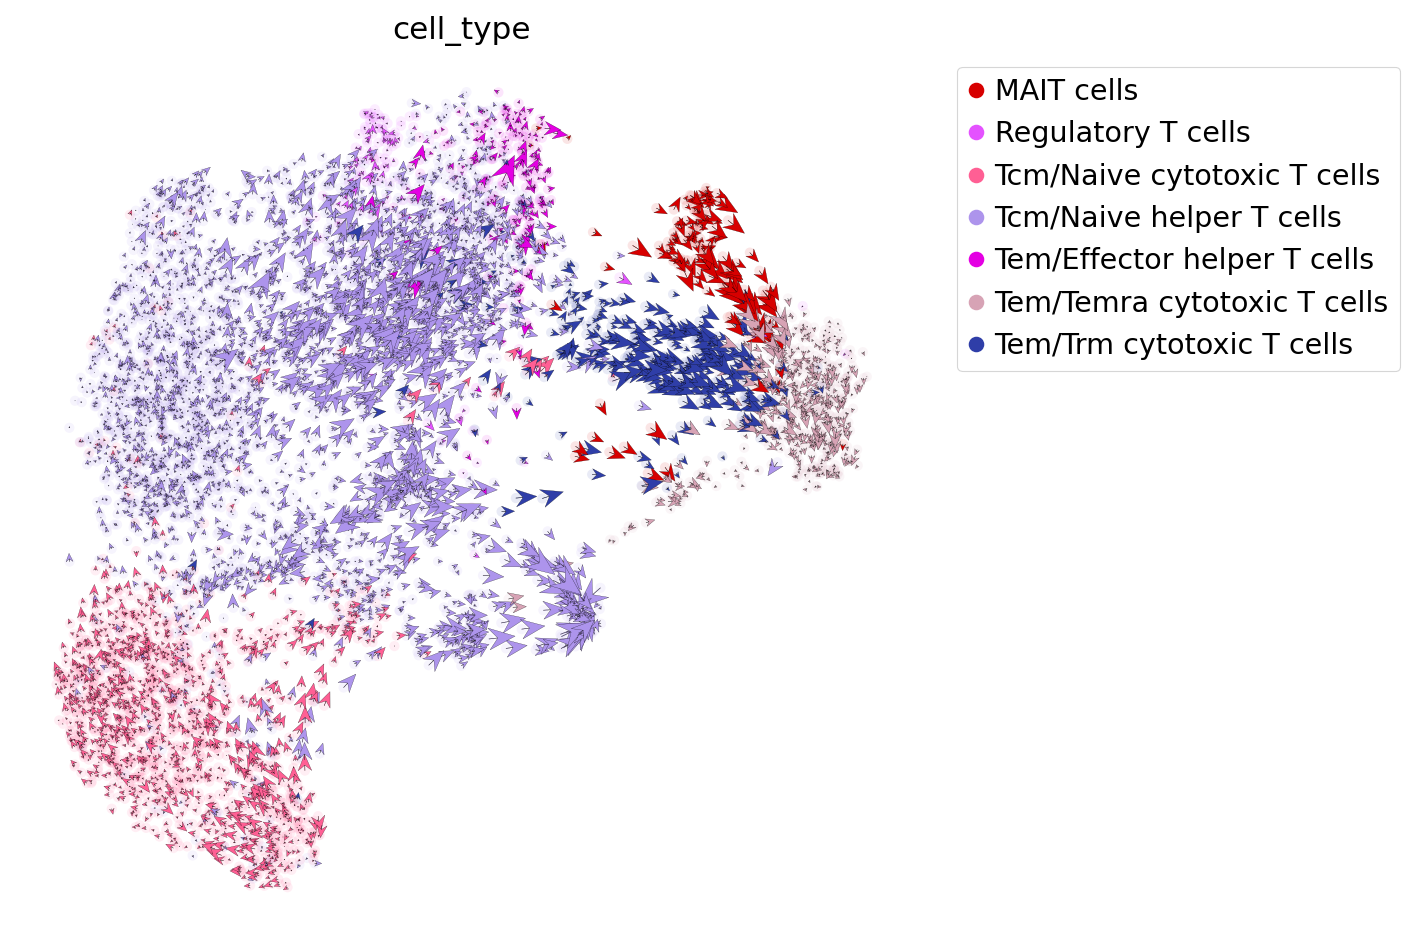

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


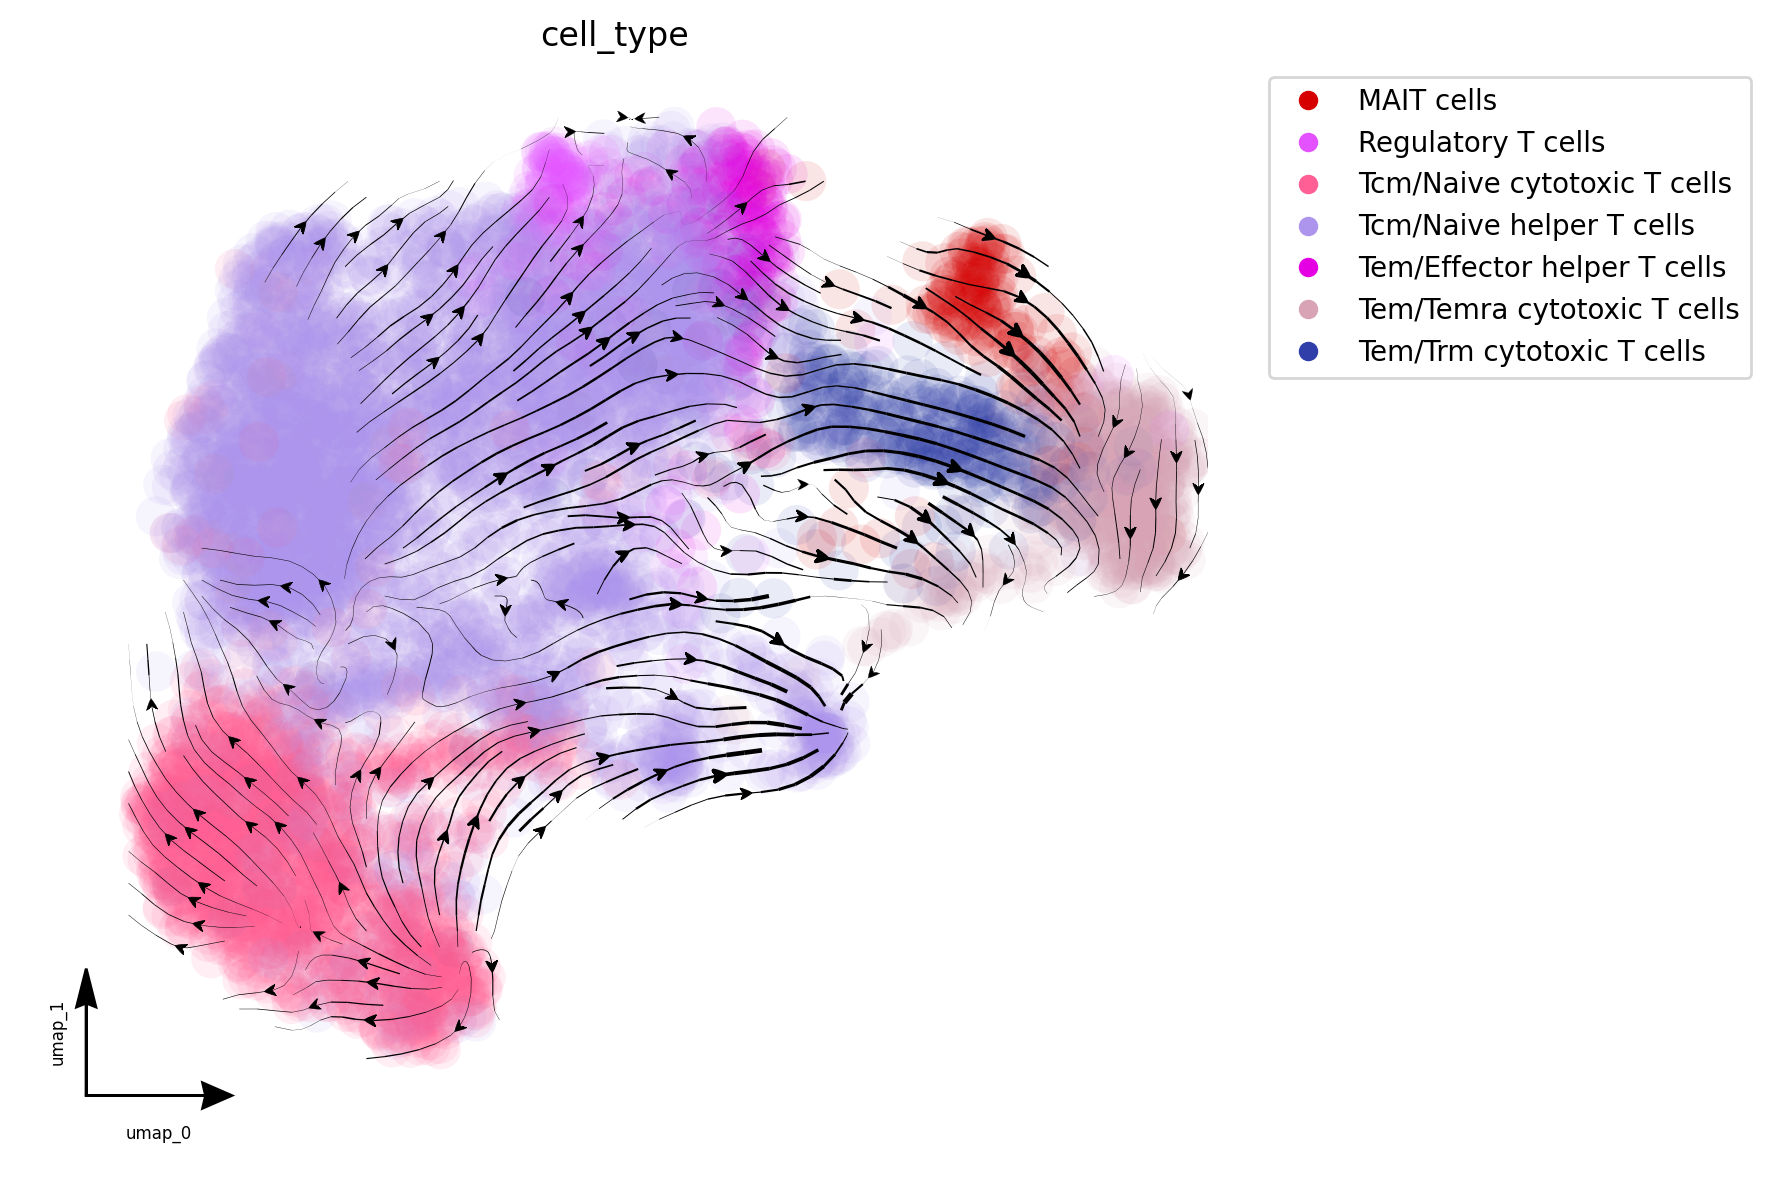

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

multi_vector_field.plot_cell_wise_vectors()
multi_vector_field.plot_streamline_plot()

## Characterization of vector field topology

|-----> Vector field for umap is not constructed. Constructing it and mapping its topography now ...
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [SparseVFC] completed [6.7965s]
|-----> Mapping topography...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [VectorField] completed [2411.6711s]
|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA_0_1. 
        Vector field

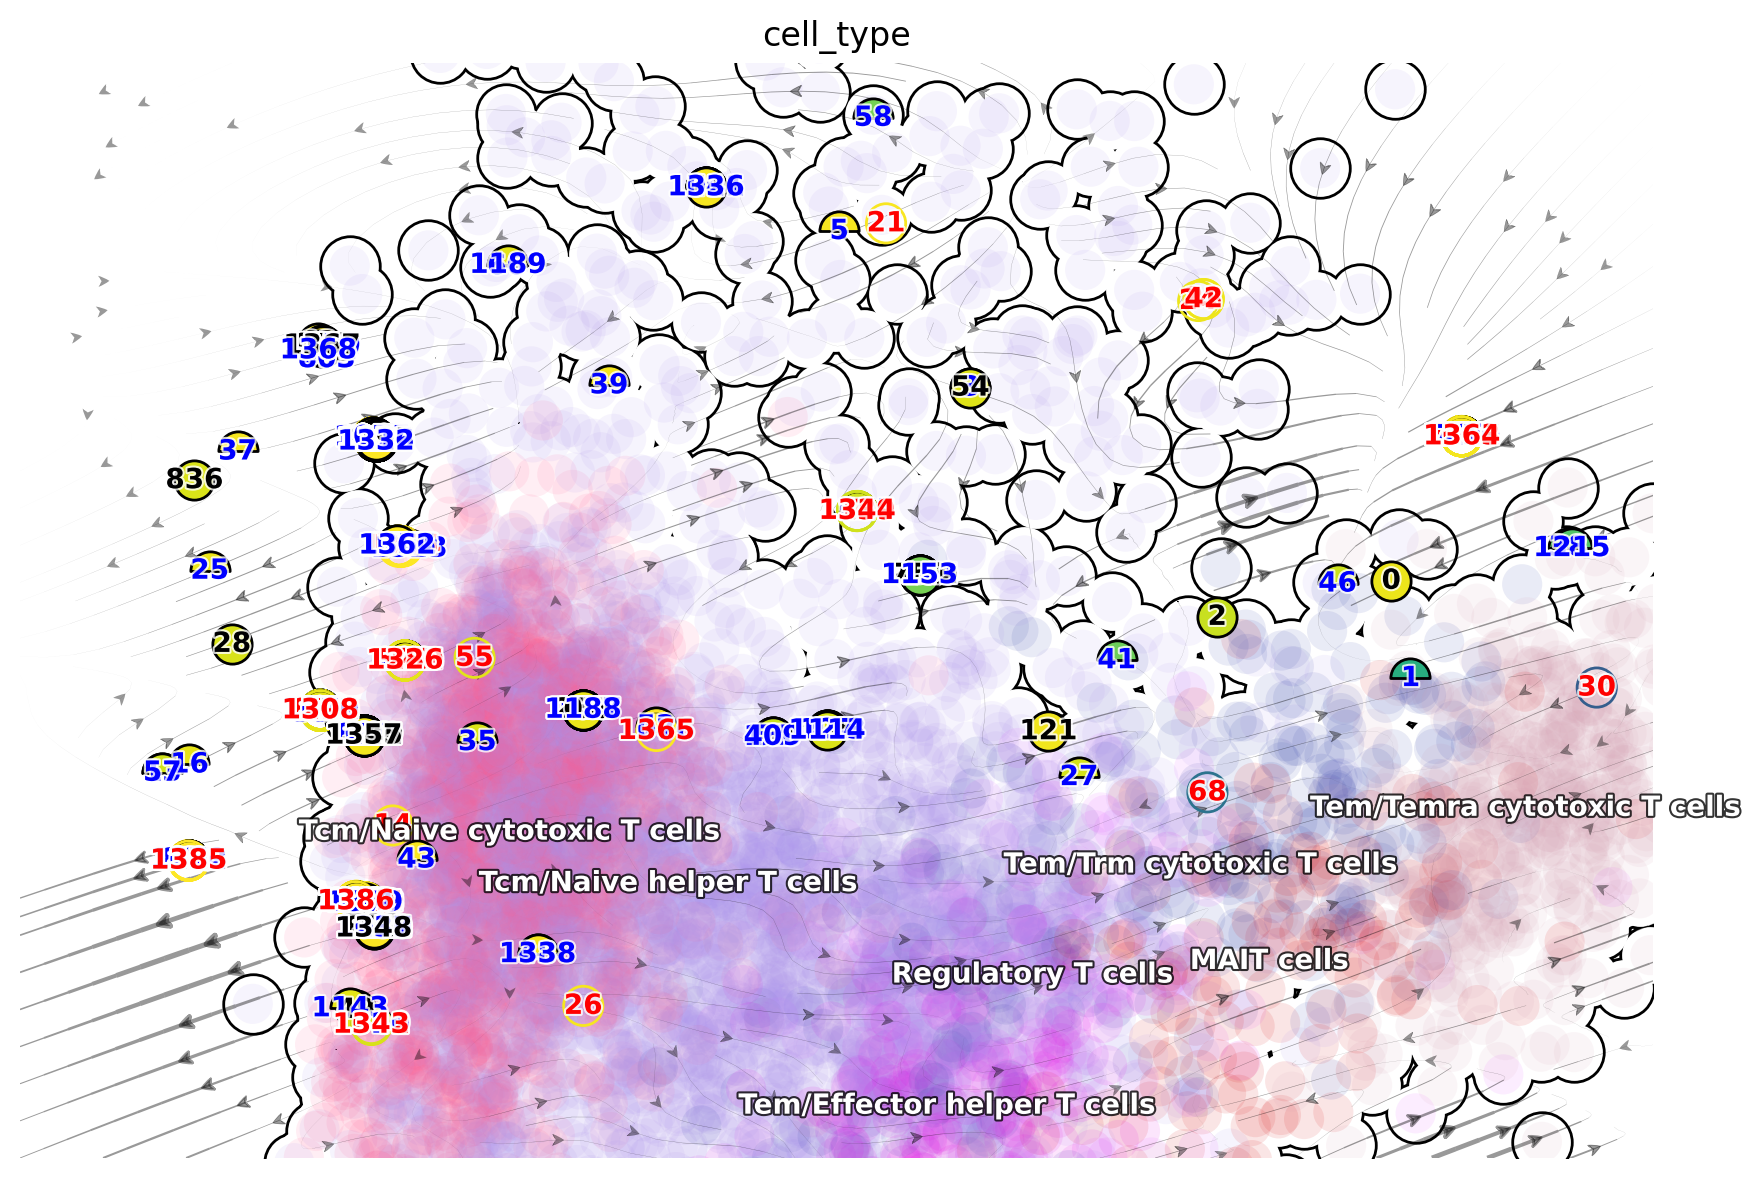

In [23]:
multi_vector_field.plot_topography()

## In silico perturbation
First we show the effects of a perturbation to a gene.

We begin by listing the genes that we can perturb:

In [24]:
# Extract information about all genes and CREs
gene_and_cre_df = multi_vector_field.multi_adata.var.copy()

# Narrow to perturbable genes
gene_df = gene_and_cre_df[gene_and_cre_df['feature_type']  == 'gene']
perturbable_gene_df = gene_df[gene_df['use_for_pca']]

# We can search for genes starting with certain letters - Interleukins are generally interesting ...
perturbable_gene_df[perturbable_gene_df.index.str.startswith('IL')]

feature_type  use_for_dynamics  use_for_pca  use_for_transition
IL2RA           gene              True         True                True
IL7R            gene              True         True                True
IL32            gene              True         True               False
IL18R1          gene              True         True               False
IL6ST           gene              True         True               False
IL4I1           gene              True         True               False
IL18RAP         gene              True         True               False
IL6R            gene              True         True               False

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....


calculating Jacobian for each cell: 100%|███████████████████████████████████████████████| 5859/5859 [00:00<00:00, 123859.29it/s]


|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [1.2659s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap_perturbation
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type
|-----------> plotting with basis key=X_umap_perturbation


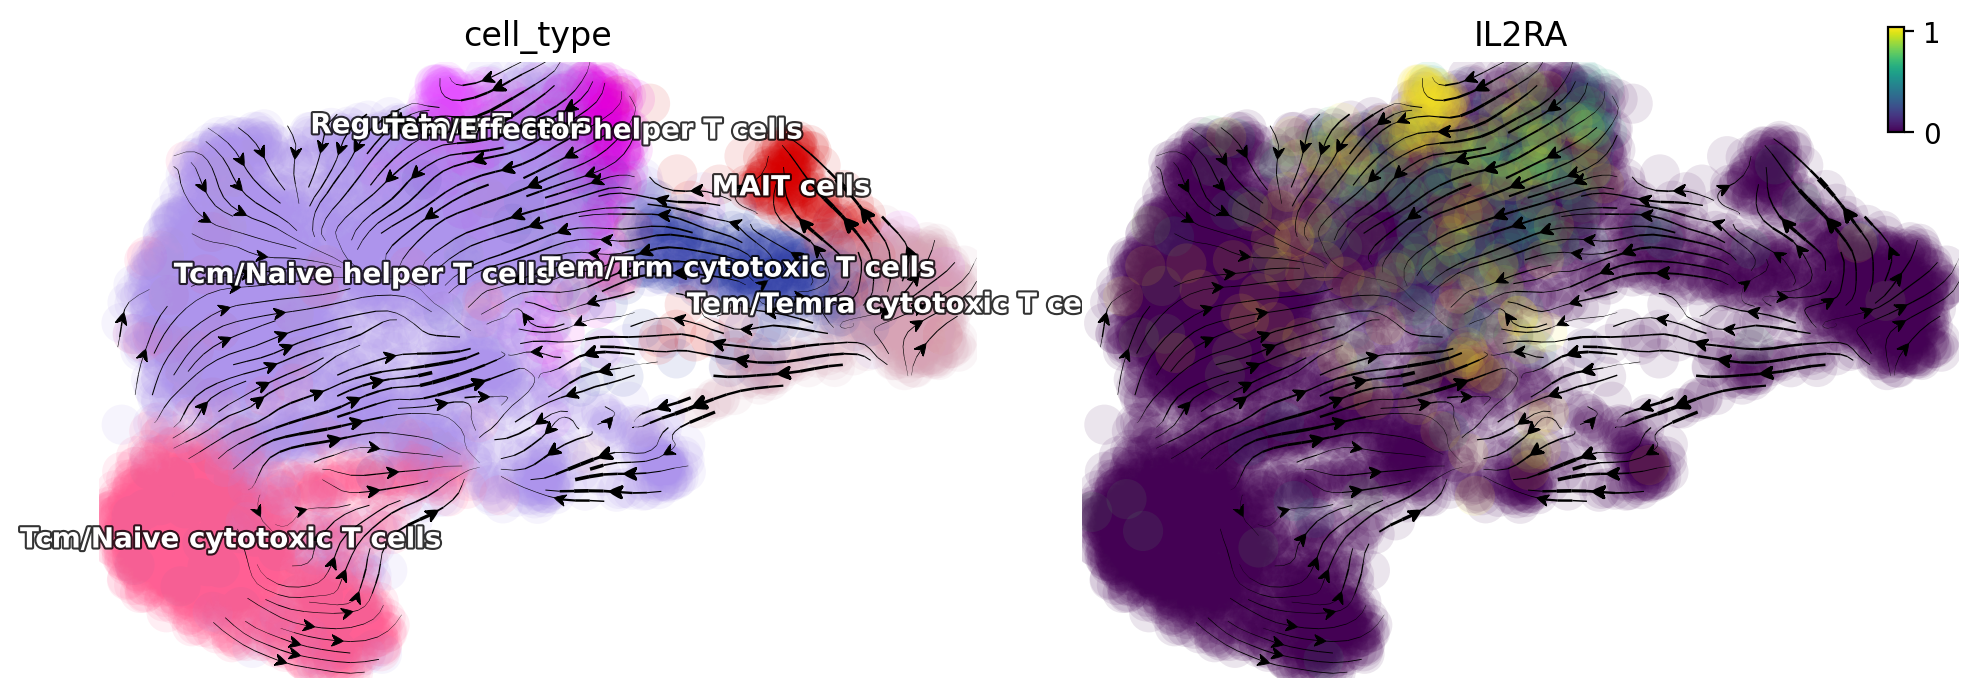

In [25]:
# Compute the perturbation to IL2 receptor alpha expresion - important in autoimmunity
multi_vector_field.predict_perturbation(gene='IL2RA',
                                        expression=50)

### Perturbations to cis regulatory elements
Here we demonstrate a computation of a perturbation to a cis-regulatory element.

In [26]:
# Extract information about all genes and CREs
gene_and_cre_df = multi_vector_field.multi_adata.var.copy()

# Narrow to perturbable CREs
cre_df = gene_and_cre_df[gene_and_cre_df['feature_type']  == 'CRE']
perturbable_cre_df = cre_df[cre_df['use_for_pca']]

# We can search for CRE on specific chromosome - IL2RA is on chr10 ...
perturbable_cre_df[perturbable_cre_df.index.str.startswith('chr10')]

feature_type  use_for_dynamics  use_for_pca  \
chr10:26437211-26440444            CRE              True         True   
chr10:69072673-69074673            CRE              True         True   
chr10:119535736-119536559          CRE              True         True   
chr10:60708621-60709108            CRE              True         True   
chr10:30432467-30438179            CRE              True         True   
...                                ...               ...          ...   
chr10:14553275-14557197            CRE              True         True   
chr10:69043606-69050211            CRE              True         True   
chr10:69050869-69059939            CRE              True         True   
chr10:32929688-32929976            CRE              True         True   
chr10:60731197-60734091            CRE              True         True   

                           use_for_transition  
chr10:26437211-26440444                  True  
chr10:69072673-69074673                  True  
chr10:119535736-119536559                True  
chr10:60708621-60709108                  True  
chr10:30432467-30438179                  True  
...                                       ...  
chr10:14553275-14557197                  True  
chr10:69043606-69050211                  True  
chr10:69050869-69059939                  True  
chr10:32929688-32929976                  True  
chr10:60731197-60734091                  True  

[113 rows x 4 columns]

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [1.2753s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap_perturbation
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type
|-----------> plotting with basis key=X_umap_perturba

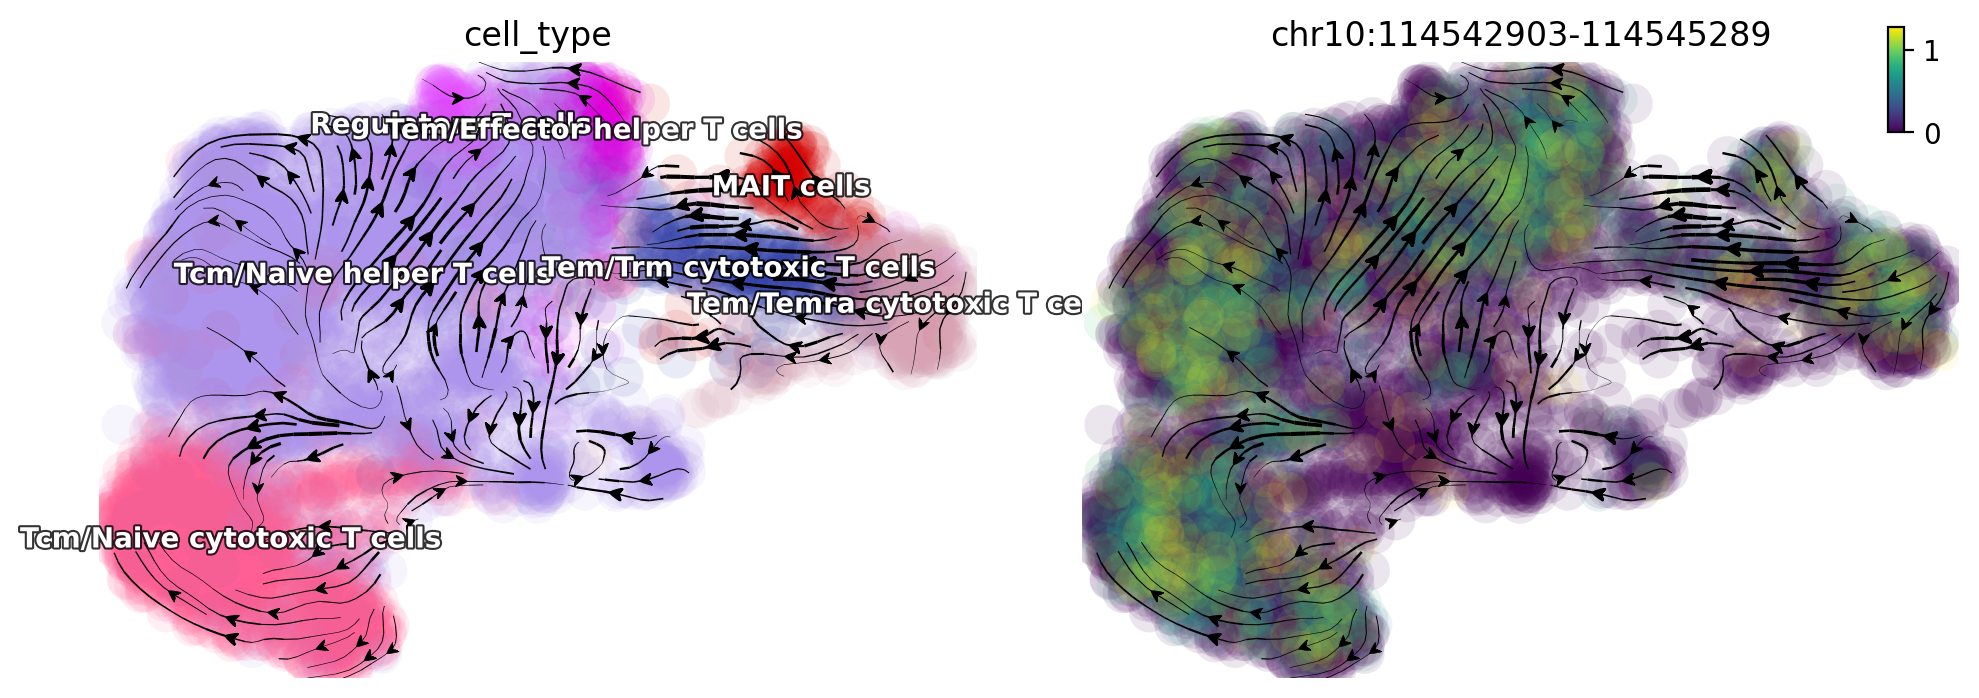

In [27]:
multi_vector_field.predict_perturbation(gene='chr10:114542903-114545289',
                                        expression=50)

In [28]:
multi_vector_field.multi_adata.write(os.path.join(CACHE_PATH, 'final_multi_adata.h5ad'))